In [3]:
import pandas as pd
import geopandas
import pypsa
import numpy as np
import math
from scipy.interpolate import interp1d
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
version = 'Base'
co2_1990 = 2232e6 # Mt co2 emission in 1990
rate = 0.02 # inflation rate
years = np.arange(2020,2055,5)
today_TV = 31

sns.set_style("ticks")
figsize=(12.8,8)
fs = 20
fs_s = 18
mew = 3
ms = 15
lw = 3
color_cf = 'r'
color_pene = 'w'
dict_rename_gas = {'gas boiler':'gas','CHP':'gas','CCGT':'gas','CHP heat':'gas','OCGT':'gas'}
dict_rename_simplified_cate = {'lignite':'conventional', 'coal':'conventional', 'gas':'conventional', \
                               'heat pump':'Power-to-heat', 'resistive heater':'Power-to-heat', \
                               'hot water storage':'balancing', 'hydrogen storage':'balancing', 'methanation':'balancing',\
                               'offshore wind':'wind and solar', 'onshore wind':'wind and solar', 'solar PV':'wind and solar'}

tech_colors = pd.read_csv('../color_scheme.csv',index_col=0,squeeze=True)

In [5]:
def rename_techs(label):
    if label[:8] == "central ":
        label = label[8:]
    if label[:6] == "urban ":
        label = label[6:]
    if "retrofitting" in label:
        label = "building retrofitting"
    if "H2" in label:
        label = "hydrogen storage"
    if "CHP" in label:
        label = "CHP"
    if "water tank" in label:
        label = "water tanks"
    if label=="water tanks":
        label = "hot water storage"
    if "gas" in label and label != "gas boiler" and label != "gas cooler":
        label = "gas"
    if "OCGT" in label:
        label = "gas turbine"
    if "CCGT" in label:
        label = "gas turbine"
    if "nuclear" in label:
        label = "nuclear"
    if "lignite" in label:
        label = "lignite"
    if "coal" in label:
        label = "coal"
    if "solar thermal" in label:
        label = "solar thermal"
    if label == "oil Store":
        label = "oil"
    if label == "solar":
        label = "solar PV"
    if "heat pump" in label:
        label = "heat pump"
    if label == "Sabatier":
        label = "methanation"
    if label == "offwind":
        label = "offshore wind"
    if label == "onwind":
        label = "onshore wind"
    if label == "ror":
        label = "hydro"
    if label == "hydro":
        label = "hydro"
    if label == "PHS":
        label = "hydro"
    if "battery" in label:
        label = "battery storage"

    return label

In [6]:
d = {'gas':0.200975592195262,
     'coal':0.336125711,
     'lignite':0.4069083447,
     'oil':0.2664698682,
    }
co2_intensity = pd.Series(d)

In [7]:
csvs = {}
base_dir = '../results/version-{}/csvs'.format(version)
csvs['costs'] = pd.read_csv('{}/costs.csv'.format(base_dir),index_col=[0,1,2],header=[0,2])
csvs['energy'] = pd.read_csv('{}/energy.csv'.format(base_dir),index_col=[0,1],header=[0,2])
csvs['supply'] = pd.read_csv('{}/supply.csv'.format(base_dir),index_col=[0,1,2],header=[0,2])
csvs['metrics'] = pd.read_csv('{}/metrics.csv'.format(base_dir),index_col=0,header=[0,2])
csvs['curtailment'] = pd.read_csv('{}/curtailment.csv'.format(base_dir),index_col=0,header=[0,1],skiprows=[1,3])

In [8]:
df = csvs['energy']
total_demand = -df.loc['loads',('go','2020')].sum()

df = df.loc['stores'].rename(mapper=rename_techs)
df = df.groupby(df.index).sum()
df = df.reindex(index=co2_intensity.index)

s_emi = df.multiply(co2_intensity,axis=0).sum()
s_emi = s_emi/co2_1990
s_uti = s_emi

In [9]:
# rates = np.linspace(0,0.1,20)
# plt.rcParams['xtick.labelsize'] = fs
# plt.rcParams['ytick.labelsize'] = fs
# fig,ax=plt.subplots(figsize=figsize)
# for rate in rates:
#     s = df.sum()
#     s_n = s.divide((1+rate)**(s.index.get_level_values(1).astype(int)-2020))
#     s_n = (s_n.groupby('scenario').sum()*5/1e9).astype(int)
#     ax.scatter(rate,s_n['go'],c='r',s=100,label='Cautious')
#     ax.scatter(rate,s_n['wait'],c='b',marker='x',s=100,label='Last-minute')

# handles,labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2],labels[:2],fontsize=fs)
# ax.set_xlabel('Rate',fontsize=fs)
# ax.set_ylabel('Net present cost',fontsize=fs)
# # plt.savefig('rate_vs_npc.pdf')

In [10]:
df = csvs['costs']

s = df.sum()
s_n = s.divide((1+rate)**(s.index.get_level_values(1).astype(int)-2020))
s_n = (s_n.groupby('scenario').sum()*5/1e9).astype(int)
s_tr = csvs['metrics'].loc['transmission capacity']

to_drop = df.index[df.max(axis=1) < 1]

df = df.drop(to_drop)
df = df.droplevel(0)
df.rename(level=1,mapper=rename_techs,inplace=True)

df_cc = df.droplevel(0).groupby(level=0).sum()/total_demand
df_cc = df_cc.rename(dict_rename_gas)
df_cc = df_cc.groupby(by=df_cc.index).sum()

df_cc = df_cc.rename(mapper=dict_rename_simplified_cate).groupby(level=0).sum()
df_cc = df_cc.reindex(['conventional','nuclear','hydro','wind and solar','Power-to-heat','balancing','transmission lines'])

df_mc = df.loc['marginal'].rename({'gas turbine':'gas'}).groupby(level=0).sum()/total_demand
df_mc = df_mc.reindex(['lignite','coal', 'gas','nuclear'])

In [11]:
df = csvs['metrics'].filter(like='uti',axis=0)
df.rename(lambda x:x[:-4],inplace=True)
df = df.rename(dict_rename_gas).groupby(level=0).mean()
df = df.reindex(df_mc.index)
df_uti = df

/home/kun/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
df_ex = csvs['metrics'].filter(like='expansion',axis=0)
df_ex = df_ex.rename(lambda x:x[:-10])/1e3 # GW per year
df_ex.rename(mapper=rename_techs,inplace=True)
df_ex = df_ex.groupby(df_ex.index).sum()
df_ex = df_ex.reindex(['lignite','coal','oil','gas turbine','gas boiler', 'nuclear',
                       'heat pump', 'resistive heater',
                       'hot water storage', 'hydrogen storage',
                       'offshore wind', 'onshore wind',  'solar PV'])
# df_ex.loc['transmission lines','go'] = s_tr['go'].values-np.insert(s_tr['go'].values[:-1],0,today_TV)
# df_ex.loc['transmission lines','wait'] = s_tr['wait'].values-np.insert(s_tr['wait'].values[:-1],0,today_TV)
df_ex.loc['transmission lines','go'] = s_tr['go'].diff().fillna(0).values/1e3
df_ex.loc['transmission lines','wait'] = s_tr['wait'].diff().fillna(0).values/1e3
df_ex.clip(lower=0,inplace=True)

In [13]:
renewable = ['onshore wind','offshore wind','solar PV']
conventional = ['lignite','coal','oil','gas turbine','gas boiler','nuclear']
PtH = ['heat pump','resistive heater']
balancing = ['battery storage','hydrogen storage','hot water storage','methanation','transmission'] #,'biomass storage']

In [14]:
df_capa = csvs['metrics'].filter(like='capacity',axis=0)
df_capa = df_capa.rename(lambda x:x[:-9])/1e3 #GW
df_capa = df_capa.rename(mapper=rename_techs).groupby(level=0).sum()

# decomposition of LCOE

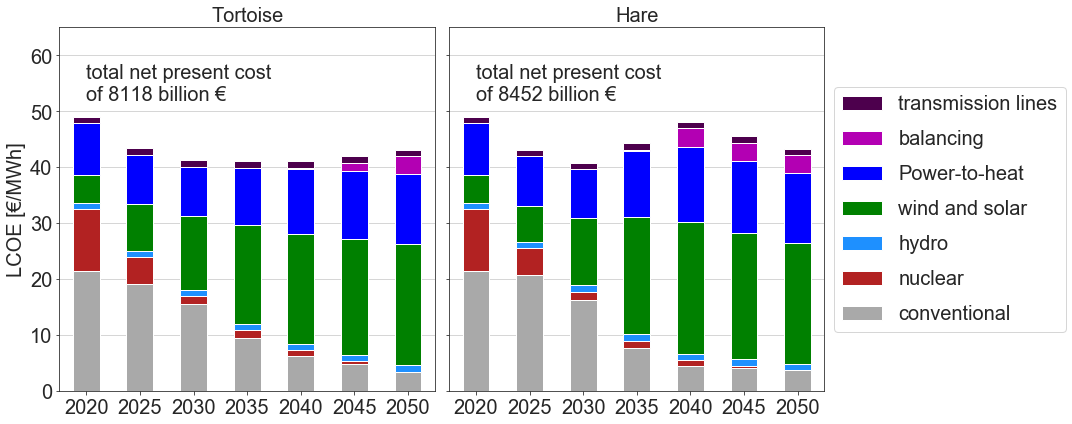

In [15]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]
df = df_cc['go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_ylim([0,65])
ax.set_xlabel('')
ax.set_ylabel("LCOE [€/MWh]",fontsize=fs)
ax.set_title('Tortoise',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present cost \nof {} billion €'.format(s_n['go']),xy=(0,52),fontsize=fs)
# ax_twin = ax.twinx()
# s_emi['go'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
# ax_twin.set_ylim([0,1])
# ax_twin.set_yticks([])

ax = axes[1]
df = df_cc['wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_title('Hare',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present cost \nof {} billion €'.format(s_n['wait']),xy=(0,52),fontsize=fs)
# ax_twin = ax.twinx()
# s_emi['wait'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
# ax_twin.set_ylim([0,1])
# ax_twin.set_ylabel("CO2 emission relative to 1990",fontsize=fs)

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],ncol=1,loc="center left",fontsize=20,bbox_to_anchor=[1,0.5],labelspacing=0.8)

fig.tight_layout()

plt.savefig('../../figures/LCOE_{}.png'.format(version),dpi=500, bbox_inches='tight')

# utilisation factor

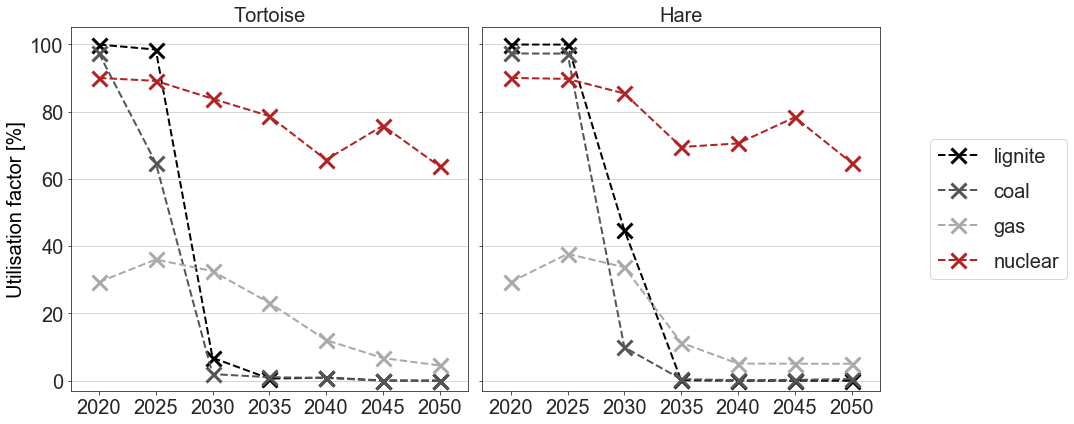

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]

df = df_uti['go']*100
df.T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='x',ms=ms,mew=mew,style='--',rot=0)
ax.set_ylabel("Utilisation factor [%]",fontsize=fs,color=tech_colors['lignite'])
ax.set_title('Tortoise',fontsize=fs)
handles1,labels1 = ax.get_legend_handles_labels()

# ax_twinx = ax.twinx()
# df = csvs['curtailment']['go'].reindex(['offwind','onwind','solar'])
# df = df.rename(mapper=rename_techs)
# df.T.plot(ax=ax_twinx,fontsize=fs,color=tech_colors[df.index],lw=0,legend=False,marker='^',ms=ms,mew=2,style=':',alpha=0.8)
# ax_twinx.set_ylim([-0.2,7])
# ax_twinx.set_yticks([])
# handles2,labels2 = ax_twinx.get_legend_handles_labels()

# dummy plot
ax = axes[0]
df.T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax = axes[1]
df = df_uti['wait']*100
df.T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='x',ms=ms,mew=mew,style='--',rot=0)
ax.set_ylim([-3,105])
ax.set_title('Hare',fontsize=fs)

# ax_twinx = ax.twinx()
# df = csvs['curtailment']['wait'].reindex(['offwind','onwind','solar'])
# df = df.rename(mapper=rename_techs)
# df.T.plot(ax=ax_twinx,fontsize=fs,color=tech_colors[df.index],lw=0,legend=False,marker='^',ms=ms,mew=2,style=':',alpha=0.8)
# ax_twinx.set_ylim([-0.2,7])
# ax_twinx.set_ylabel('Wind and solar curtailment [%]',fontsize=fs,color=tech_colors['wind and solar'])

# dummy plot
df.T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax.legend(handles1,labels1,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.1,0.5],labelspacing=0.8)

fig.tight_layout()
plt.savefig('../../figures/utilisation_factors_{}.png'.format(version),dpi=500, bbox_inches='tight')

# revenue v.s. expenditure

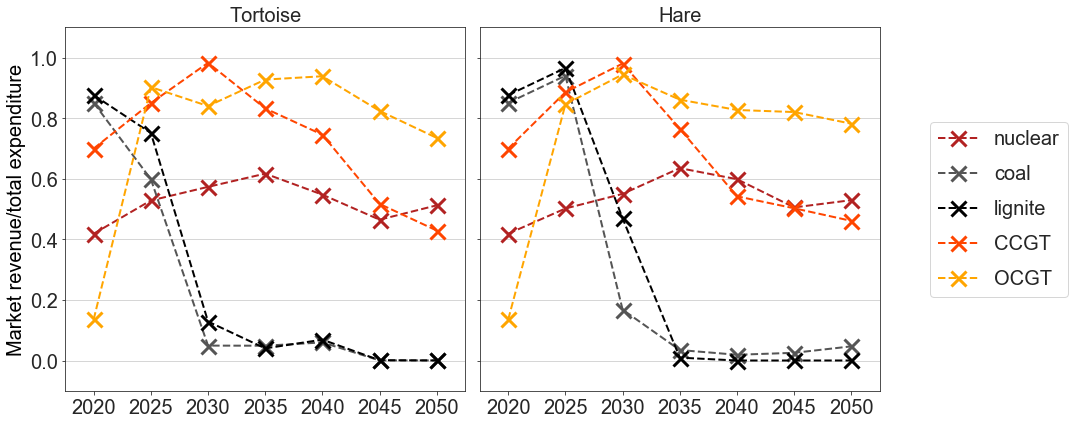

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

df = csvs['metrics']
revenue = df.filter(like='revenue',axis=0).rename(index=lambda x:x[:-8])
gas_fuel_cost = df.filter(like='fuel cost',axis=0).rename(index=lambda x:x[:-10])

df = csvs['costs']
expenditure = df.groupby(level=2).sum().loc[revenue.index]
index = set(gas_fuel_cost.index).intersection(expenditure.index)
expenditure.loc[index] += gas_fuel_cost.loc[index]
expenditure.loc['CCGT'] += gas_fuel_cost.loc['CCGT']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['OCGT'] += gas_fuel_cost.loc['OCGT']/20.1*co2_intensity['gas']*csvs['metrics'].loc['co2_price']
expenditure.loc['lignite'] += csvs['energy'].loc[('stores','lignite store')]*co2_intensity['lignite']*csvs['metrics'].loc['co2_price']
expenditure.loc['coal'] += csvs['energy'].loc[('stores','coal store')]*co2_intensity['coal']*csvs['metrics'].loc['co2_price']

df = revenue/expenditure

ax = axes[0]
df['go'].T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='x',ms=ms,mew=mew,style='--',rot=0)
ax.set_ylabel("Market revenue/total expenditure",fontsize=fs,color=tech_colors['lignite'])
ax.set_title('Tortoise',fontsize=fs)
handles1,labels1 = ax.get_legend_handles_labels()

df['go'].T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax = axes[1]
df['wait'].T.plot(ax=ax,fontsize=fs,color=tech_colors[df.index],lw=2,legend=False,marker='x',ms=ms,mew=mew,style='--',rot=0)
ax.set_ylim([-0.1,1.1])
ax.set_title('Hare',fontsize=fs)
handles2,labels2 = ax.get_legend_handles_labels()

df['wait'].T.plot(kind='bar',ax=ax,stacked=True,fontsize=fs,color=tech_colors[df.index],lw=lw,legend=False,alpha=0,rot=0)
ax.set_xlabel("")
ax.grid('on',axis='y')

ax.legend(handles1,labels1,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.1,0.5],labelspacing=0.8)
fig.tight_layout()
plt.savefig('../../figures/revenue_vs_expenditure_{}.png'.format(version),dpi=500, bbox_inches='tight')

# expansion rates

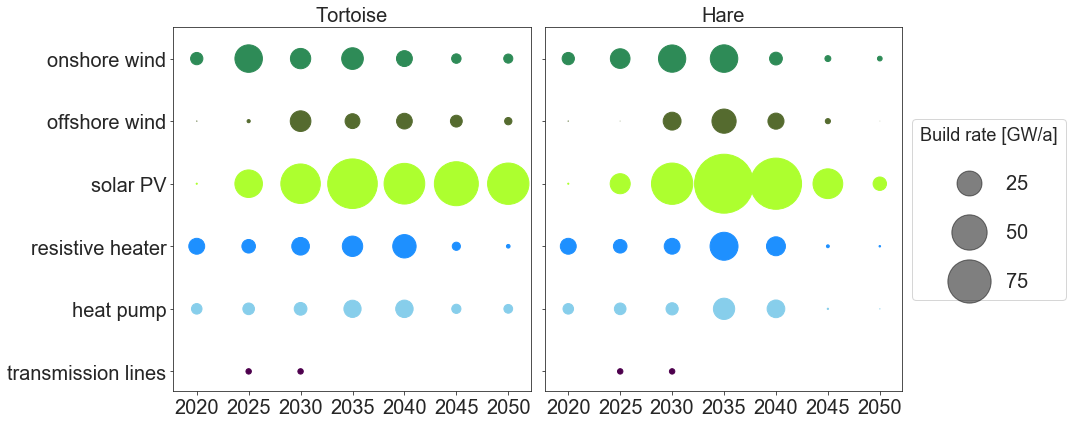

In [18]:
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

scale = 25

ax = axes[0]
df = df_ex.loc[['transmission lines']+PtH+renewable[::-1],'go']/5
x,y = np.meshgrid(years,df.index)
scatter = ax.scatter(x=x.flatten(),y=y.flatten(),s=df.values*scale,c=[tech_colors[i] for i in y.flatten()])
ax.set_title('Tortoise',fontsize=fs)
_=ax.set_xticks(np.arange(2020,2055,5))
_=ax.set_xticklabels(np.arange(2020,2055,5))

ax = axes[1]
df = df_ex.loc[['transmission lines']+PtH+renewable[::-1],'wait']/5
x,y = np.meshgrid(years,df.index)
ax.scatter(x=x.flatten(),y=y.flatten(),s=df.values*scale,c=[tech_colors[i] for i in y.flatten()])
ax.set_title('Hare',fontsize=fs)
_=ax.set_xticks(np.arange(2020,2055,5))
_=ax.set_xticklabels(np.arange(2020,2055,5))

handles, labels = scatter.legend_elements(prop="sizes",alpha=0.5,num=4,func=lambda x: x/scale)
legend = ax.legend(handles,labels,ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1,0.5],labelspacing=1.5)
legend.set_title('Build rate [GW/a]',prop={'size':fs_s})

fig.tight_layout()
plt.savefig('../../figures/build_rates_{}.png'.format(version),dpi=500,bbox_inches='tight')

# accumulative power and heating capacities

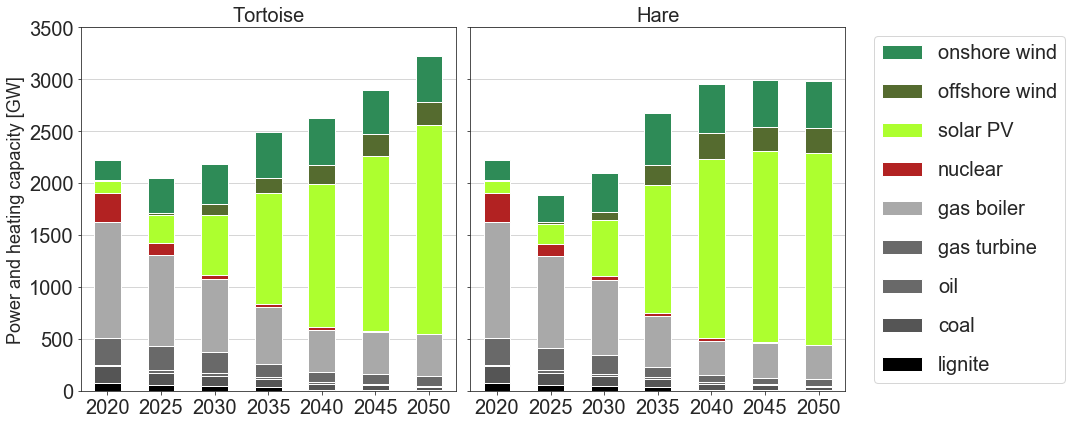

In [19]:
fig, axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey='row')

ax = axes[0]
df = df_capa.loc[conventional+renewable[::-1],'go'].dropna()
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_ylabel("Power and heating capacity [GW]",fontsize=fs_s)
ax.set_title('Tortoise',fontsize=fs)
ax.grid('on',axis='y')
ax.set_ylim(0,3500)

ax = axes[1]
df = df_capa.loc[conventional+renewable[::-1],'wait'].dropna()
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs,rot=0)
ax.set_xlabel('')
ax.set_title('Hare',fontsize=fs)
ax.grid('on',axis='y')

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],ncol=1,loc="center left",fontsize=fs,bbox_to_anchor=[1.05,0.5],labelspacing=1)

fig.tight_layout()
plt.savefig('../../figures/installed_capacity_{}.png'.format(version),dpi=500, bbox_inches='tight')

# country-level electricity production

In [20]:
df = pd.read_csv('../results/version-{}/electricity_production_{}_go.csv'.format(version,version),index_col=0,header=[0,1])
index = ['lignite','coal','oil','gas','nuclear','hydro','solar','onwind','offwind']
df = df.reindex(index)
to_drop = df.index[df.max(axis=1) < 1]
df.drop(index=to_drop,inplace=True)
df.rename(index=rename_techs,inplace=True)
df_EU = df.droplevel(0,axis=1).groupby(level=0,axis=1).sum()

filename_countries = '../data/Country_codes_REINVEST_short.csv'
countries_list = pd.read_csv(filename_countries, sep=';', encoding='latin-1', index_col=3)
#dictionary to convert 2-letter country code intocountry name
dict_2toname = pd.Series(dict(zip(countries_list['2 letter code (ISO-3166-2)'].tolist(),
                countries_list['Country'].tolist())))
df.rename(mapper=dict_2toname,axis=1,inplace=True)

countries = df.columns.get_level_values(0).drop_duplicates().sort_values()

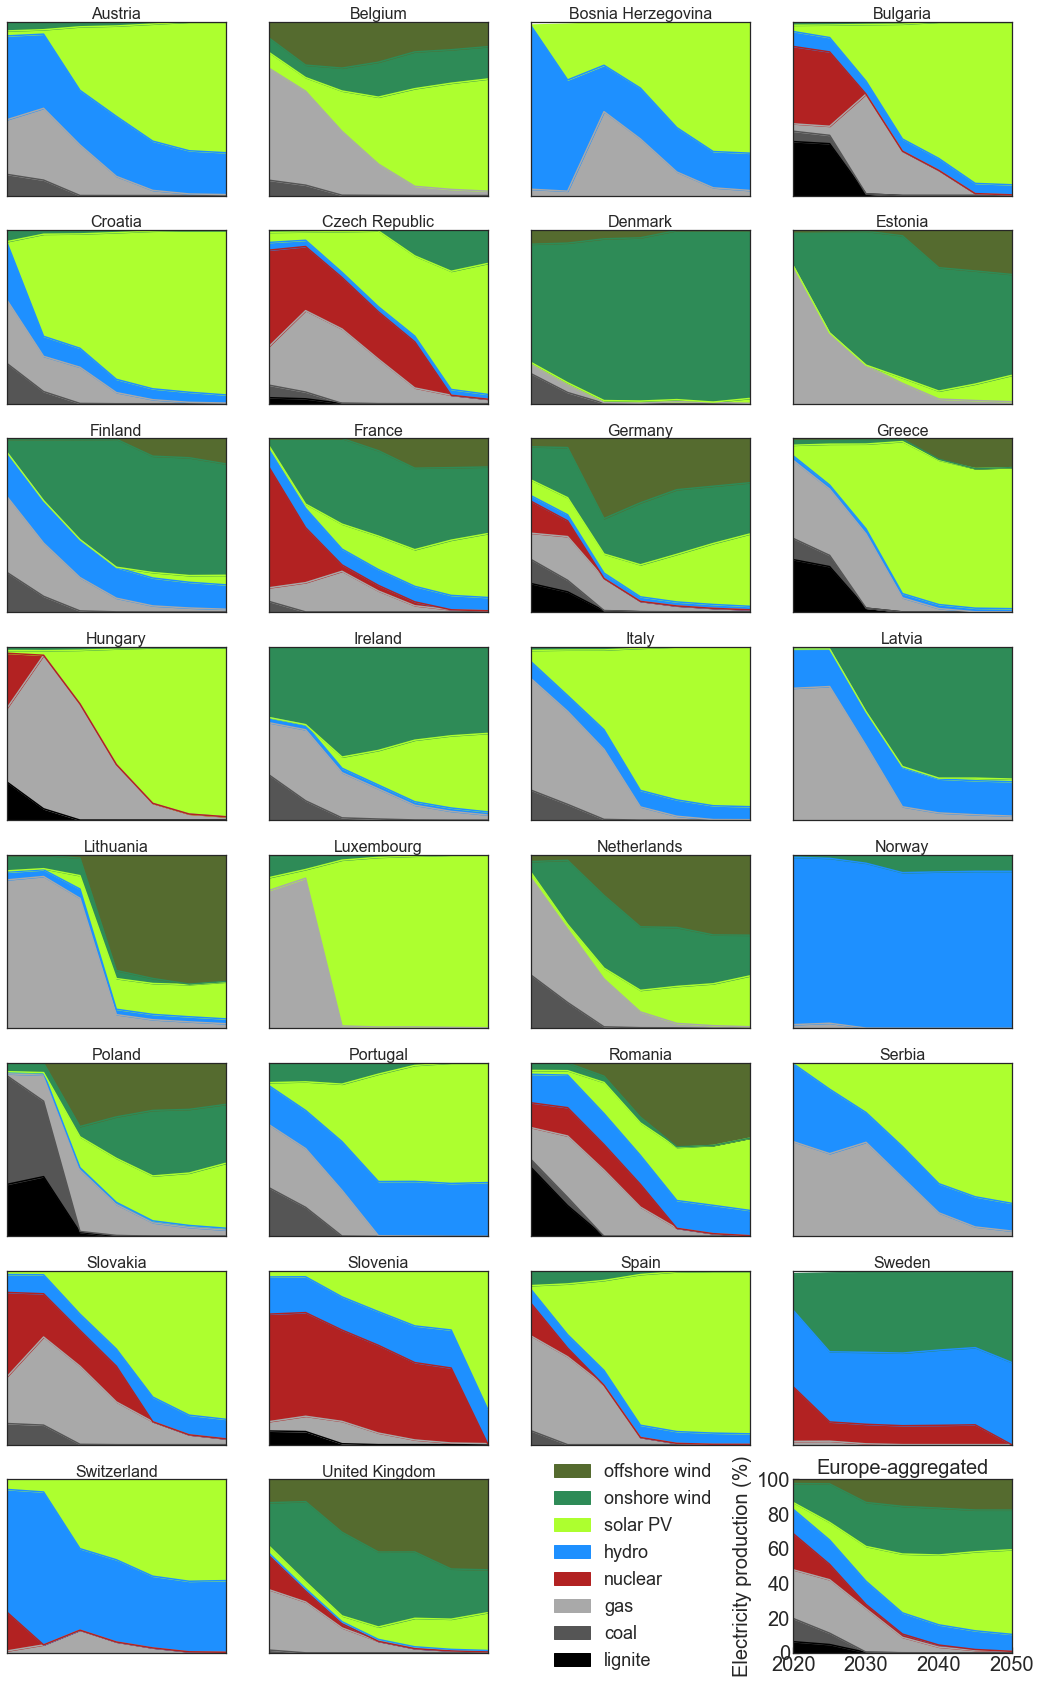

In [21]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import seaborn as sns; sns.set()
sns.set_style('ticks')
plt.style.use('seaborn-ticks')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

fig = plt.figure(figsize=(18,30))
gs = gridspec.GridSpec(8, 4)

for i, country in enumerate(countries):
    df_ = df[country]
    df_ = df_/df_.sum()
    to_drop = df_.index[df_.abs().max(axis=1) < 0.01]
    df_.drop(index=to_drop,inplace=True)
    ax = fig.add_subplot(gs[i//4, i-(i//4)*4])
    df_.T.plot.area(ax=ax,legend=False,color=[tech_colors[i] for i in df_.index])
    ax.set_ylim(0,1)
    ax.set_title(country, fontsize=16,pad=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('')
    
ax = fig.add_subplot(gs[7,3])
df_EU = df_EU/df_EU.sum()
df_EU.T.plot.area(ax=ax,color=[tech_colors[i] for i in df_EU.index])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=1,fontsize=fs_s,loc='center right',bbox_to_anchor=(-0.3,0.5))
ax.set_ylabel('Electricity production (%)', fontsize=fs)
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels(np.arange(0,120,20))
ax.set_title('Europe-aggregated', fontsize=fs)
ax.set_xlabel('')
plt.savefig('../../figures/electricity_production_{}_go.png'.format(version), dpi=300, bbox_inches='tight')

# country-level heating production

In [22]:
df = pd.read_csv('../results/version-{}/heat_production_{}_go.csv'.format(version,version),index_col=0,header=[0,1])
df.rename(index={'gas boiler':'gas','CHP heat':'gas'},inplace=True)
index = ['gas', 'resistive heater', 'heat pump']
df = df.groupby(level=0).sum().reindex(index=index)
df_EU = df.droplevel(level='country',axis=1).groupby(level=0,axis=1).sum()
df.rename(mapper=dict_2toname,axis=1,inplace=True)

countries = df.columns.get_level_values(0).drop_duplicates().sort_values()

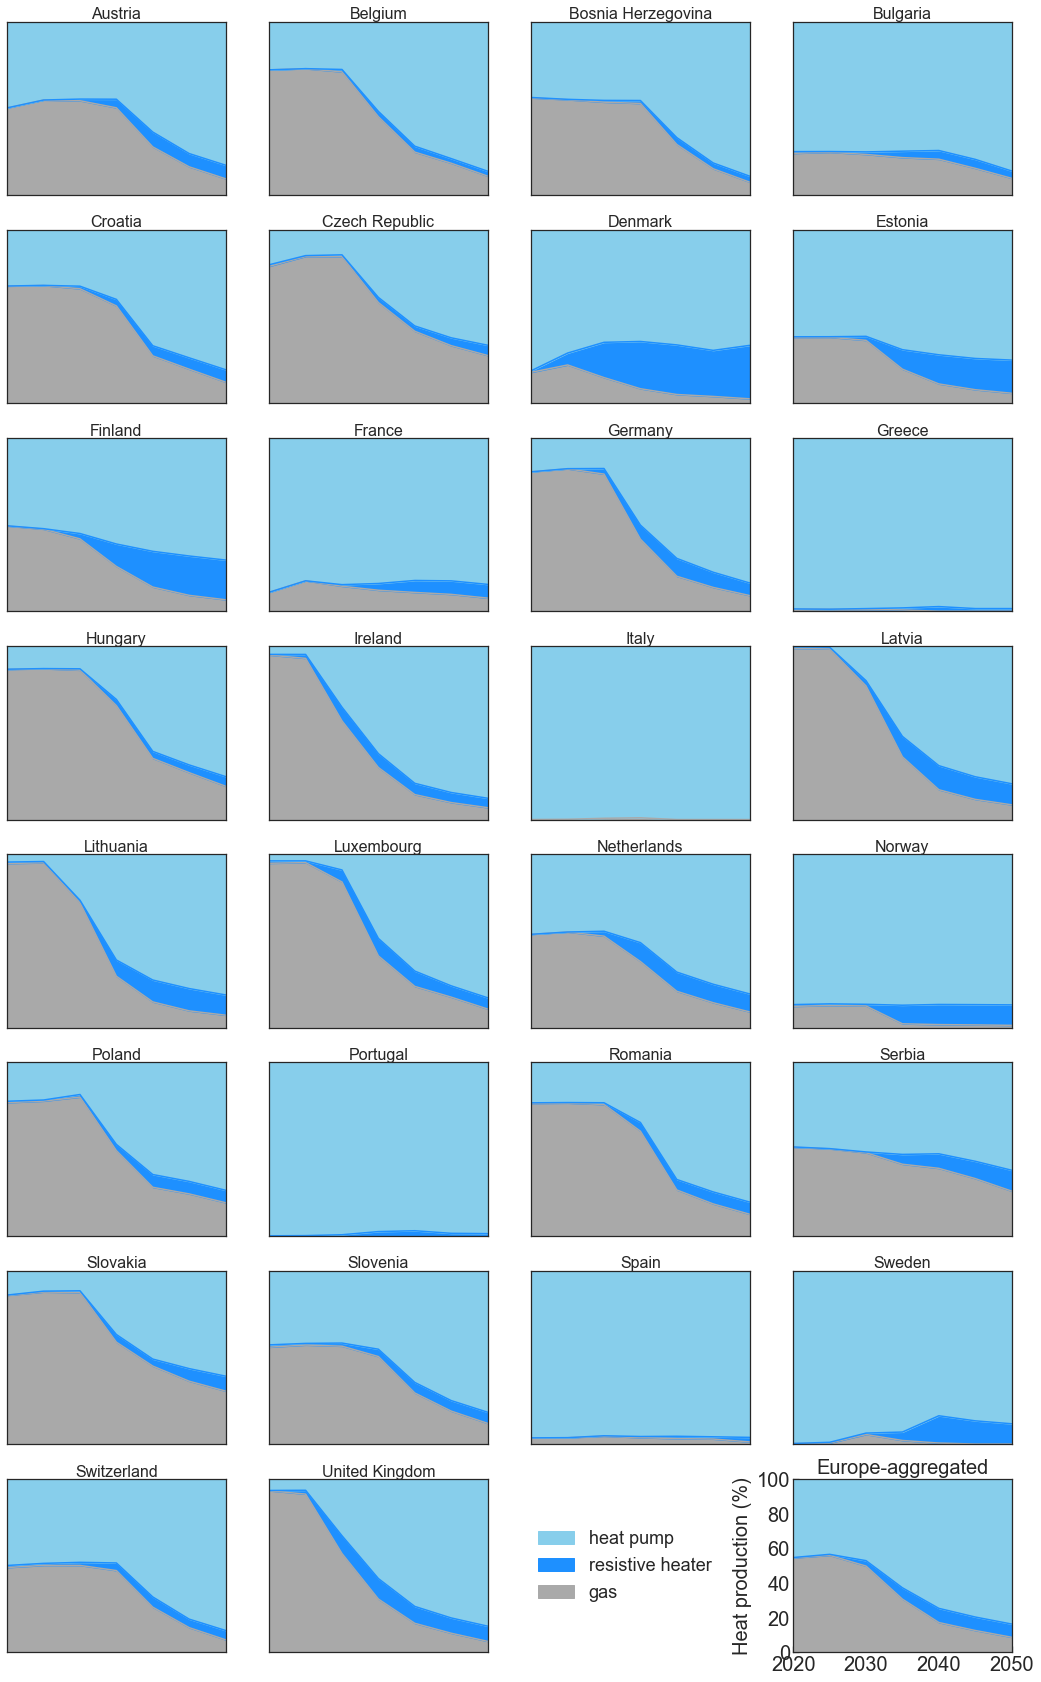

In [23]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import seaborn as sns; sns.set()
sns.set_style('ticks')
plt.style.use('seaborn-ticks')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

fig = plt.figure(figsize=(18,30))
gs = gridspec.GridSpec(8, 4)

for i, country in enumerate(countries):
    df_ = df[country]
    df_ = df_/df_.sum()
    to_drop = df_.index[df_.abs().max(axis=1) < 0.01]
    df_.drop(index=to_drop,inplace=True)
    ax = fig.add_subplot(gs[i//4, i-(i//4)*4])
    df_.T.plot.area(ax=ax,legend=False,color=[tech_colors[i] for i in df_.index])
    ax.set_ylim(0,1)
    ax.set_title(country, fontsize=16,pad=0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('')
    
ax = fig.add_subplot(gs[7,3])
df_EU = df_EU/df_EU.sum()
df_EU.T.plot.area(ax=ax,color=[tech_colors[i] for i in df_EU.index])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=1,fontsize=fs_s,loc='center right',bbox_to_anchor=(-0.3,0.5))
ax.set_ylabel('Heat production (%)', fontsize=fs)
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels(np.arange(0,120,20))
ax.set_title('Europe-aggregated', fontsize=fs)
ax.set_xlabel('')
plt.savefig('../../figures/heat_production_{}_go.png'.format(version), dpi=300, bbox_inches='tight')